In [62]:
!pip install catalax

In [1]:
import json
import jax.numpy as jnp
import catalax as ctx
import catalax.neural as ctn
from tqdm import tqdm
import numpy as np
import catalax as ctx
import catalax.mcmc as cmc
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

import catalax as ctx
import catalax.neural as cnn
import catalax.mcmc as cmc
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import Divider, Size

ctx.set_host_count(10)

# Pretraining 

In [2]:
# Initialize the model
model = ctx.Model(name="PGM ENO")

# Add species
model.add_species("s0")
model.add_species("s1")
model.add_species("s2")

# Add ODEs
model.add_ode("s0", "- (vf_pgm/k_p3ga_pgm)*(s0-s1/keq_pgm)/(1+(s1/k_p2ga_pgm)+(s0/k_p3ga_pgm))")
model.add_ode("s1", 
              """(vf_pgm/k_p3ga_pgm)*(s0-s1/keq_pgm)/(1+(s1/k_p2ga_pgm)+(s0/k_p3ga_pgm))
              - (vf_eno/k_p2ga_eno)*(s1-s2/keq_eno)/(1+(s1/k_p2ga_eno)+(s2/k_PEP_eno))
              """
             )
model.add_ode("s2", "(vf_eno/k_p2ga_eno)*(s1-s2/keq_eno)/(1+(s1/k_p2ga_eno)+(s2/k_PEP_eno))")

# Prepare the model for bayes and define priors 
model.parameters.vf_eno.value = 1.35
model.parameters.vf_pgm.value = 9.4
model.parameters.keq_pgm.value = 0.19
model.parameters.keq_eno.value = 6.7
model.parameters.k_p2ga_pgm.value = 0.08
model.parameters.k_p3ga_pgm.value = 1.2
model.parameters.k_p2ga_eno.value = 0.04
model.parameters.k_PEP_eno.value = 0.5

model

Model summary


Eq(x, Matrix([[s0, s1, s2]]))

Eq(theta, Matrix([[k_p2ga_pgm, k_p3ga_pgm, keq_pgm, vf_pgm, vf_eno, k_PEP_eno, keq_eno, k_p2ga_eno]]))

Eq(Derivative(s0, t), -vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)))

Eq(Derivative(s1, t), vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)) - vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

Eq(Derivative(s2, t), vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

name      symbol  value  constant initial_value equation lower_bound  \
0   k_PEP_eno   k_PEP_eno   0.50     False          None     None        None   
1  k_p2ga_eno  k_p2ga_eno   0.04     False          None     None        None   
2  k_p2ga_pgm  k_p2ga_pgm   0.08     False          None     None        None   
3  k_p3ga_pgm  k_p3ga_pgm   1.20     False          None     None        None   
4     keq_eno     keq_eno   6.70     False          None     None        None   
5     keq_pgm     keq_pgm   0.19     False          None     None        None   
6      vf_eno      vf_eno   1.35     False          None     None        None   
7      vf_pgm      vf_pgm   9.40     False          None     None        None   

  upper_bound  
0        None  
1        None  
2        None  
3        None  
4        None  
5        None  
6        None  
7        None

## Training Set 

In [3]:
data = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Testing Set 1/Data_Training_Set_1_20242309.npy")
time = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Testing Set 1/Time_Training_Set_1_20240923.npy")
y0s = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Testing Set 1/Training_Set_1_Initials_20242309.npy")
initial_conditions = json.load(open("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Testing Set 1/Corrected_model_1_20242309.json", "r"))  
print(f"Time: {time.shape} | Data: {data.shape} | Initial Conditions: {y0s.shape}")
print(data.shape)
print(time.shape)
print(y0s.shape)



Time: (30, 15) | Data: (30, 15, 3) | Initial Conditions: (30, 3)
(30, 15, 3)
(30, 15)
(30, 3)


## Validation set 

In [4]:
val_data = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/D and E/Validation_Set_D_and_E_20242309.npy")
val_time = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/D and E/Time_Validation_Set_D_and_E_20242309.npy")
val_y0s = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/D and E/Validation_Set_D_and_E_Initials_20242309.npy")
val_initial_conditions = json.load(open("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/D and E/model_Validation_Set_D_and_E_20242309.json", "r"))  

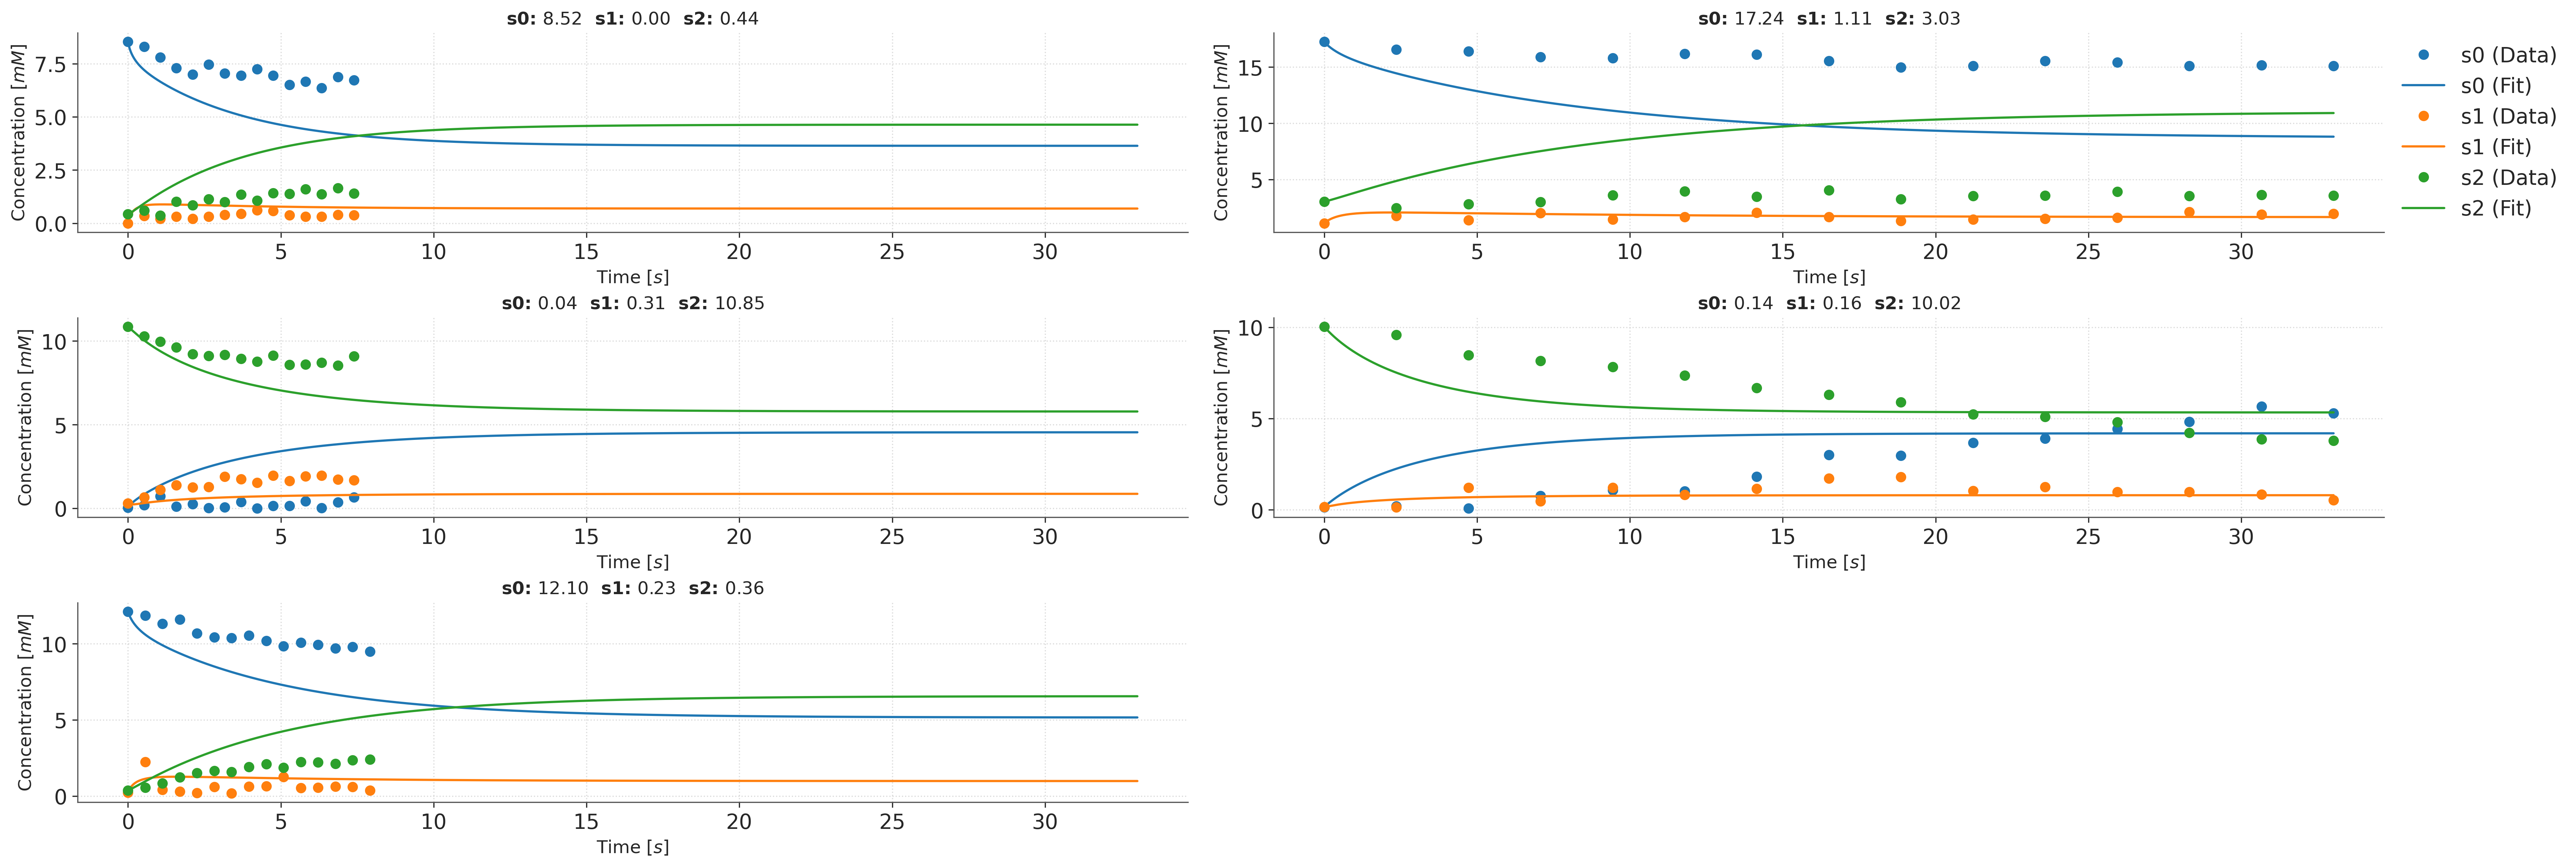

In [6]:
# Visualize the data
f = ctx.visualize(
    model=model,
    data=data[:5],
    times=time[:5],
    initial_conditions=initial_conditions[:5],
    figsize=(8,4),
)

# Training 

In [7]:
# Create a neural ODE model
rbf = ctn.RBFLayer(0.6)
neural_ode = ctn.NeuralODE.from_model(model, width_size=16, depth=1, activation=rbf)

# Set up a training strategy (You can interchange the loss function too!)
strategy = ctn.Strategy()
strategy.add_step(lr=1e-3, length=0.1, steps=1000, batch_size=32, alpha=0.1)
strategy.add_step(lr=1e-3, steps=3000, batch_size=32, alpha=0.01)
strategy.add_step(lr=1e-4, steps=5000, batch_size=32, alpha=0.01)

# Train neural ODE
trained = ctn.train_neural_ode(
    model=neural_ode,
    data=data,
    times=time,
    inital_conditions=y0s,
    strategy=strategy,
    sigma=0.03,
    n_augmentations=10,
    print_every=10,
    weight_scale=1e-3,
    save_milestones=False, # Set to True to save model checkpoints
    # log="progress.log", # Uncomment this line to log progress
)

C:\Users\danic\anaconda3\envs\test\Lib\site-packages\catalax\neural\rbf.py:25: FutureWarning: uniform accepts a single key, but was given a key array of shape (1, 2) != (). Use jax.vmap for batching. In a future JAX version, this will be an error.
  self.mu = jax.random.uniform(mukey, (width_size,))



🚀 Training NeuralODE...

🔸 Step #1
├── lr: 0.001
├── batch size: 32
├── length: 10.0%
├── l2 reg: 0.1
├── train: mlp
│


╰── loss: 0.0798 mae: 0.2161: : 1010it [00:33, 29.88it/s]                                                              




🔸 Step #2
├── lr: 0.001
├── batch size: 32
├── length: 100.0%
├── l2 reg: 0.01
├── train: mlp
│


╰── loss: 0.2900 mae: 0.4920: : 3010it [01:04, 46.61it/s]                                                              




🔸 Step #3
├── lr: 0.0001
├── batch size: 32
├── length: 100.0%
├── l2 reg: 0.01
├── train: mlp
│


╰── loss: 0.2812 mae: 0.4822: : 5010it [01:17, 64.91it/s]                                                              

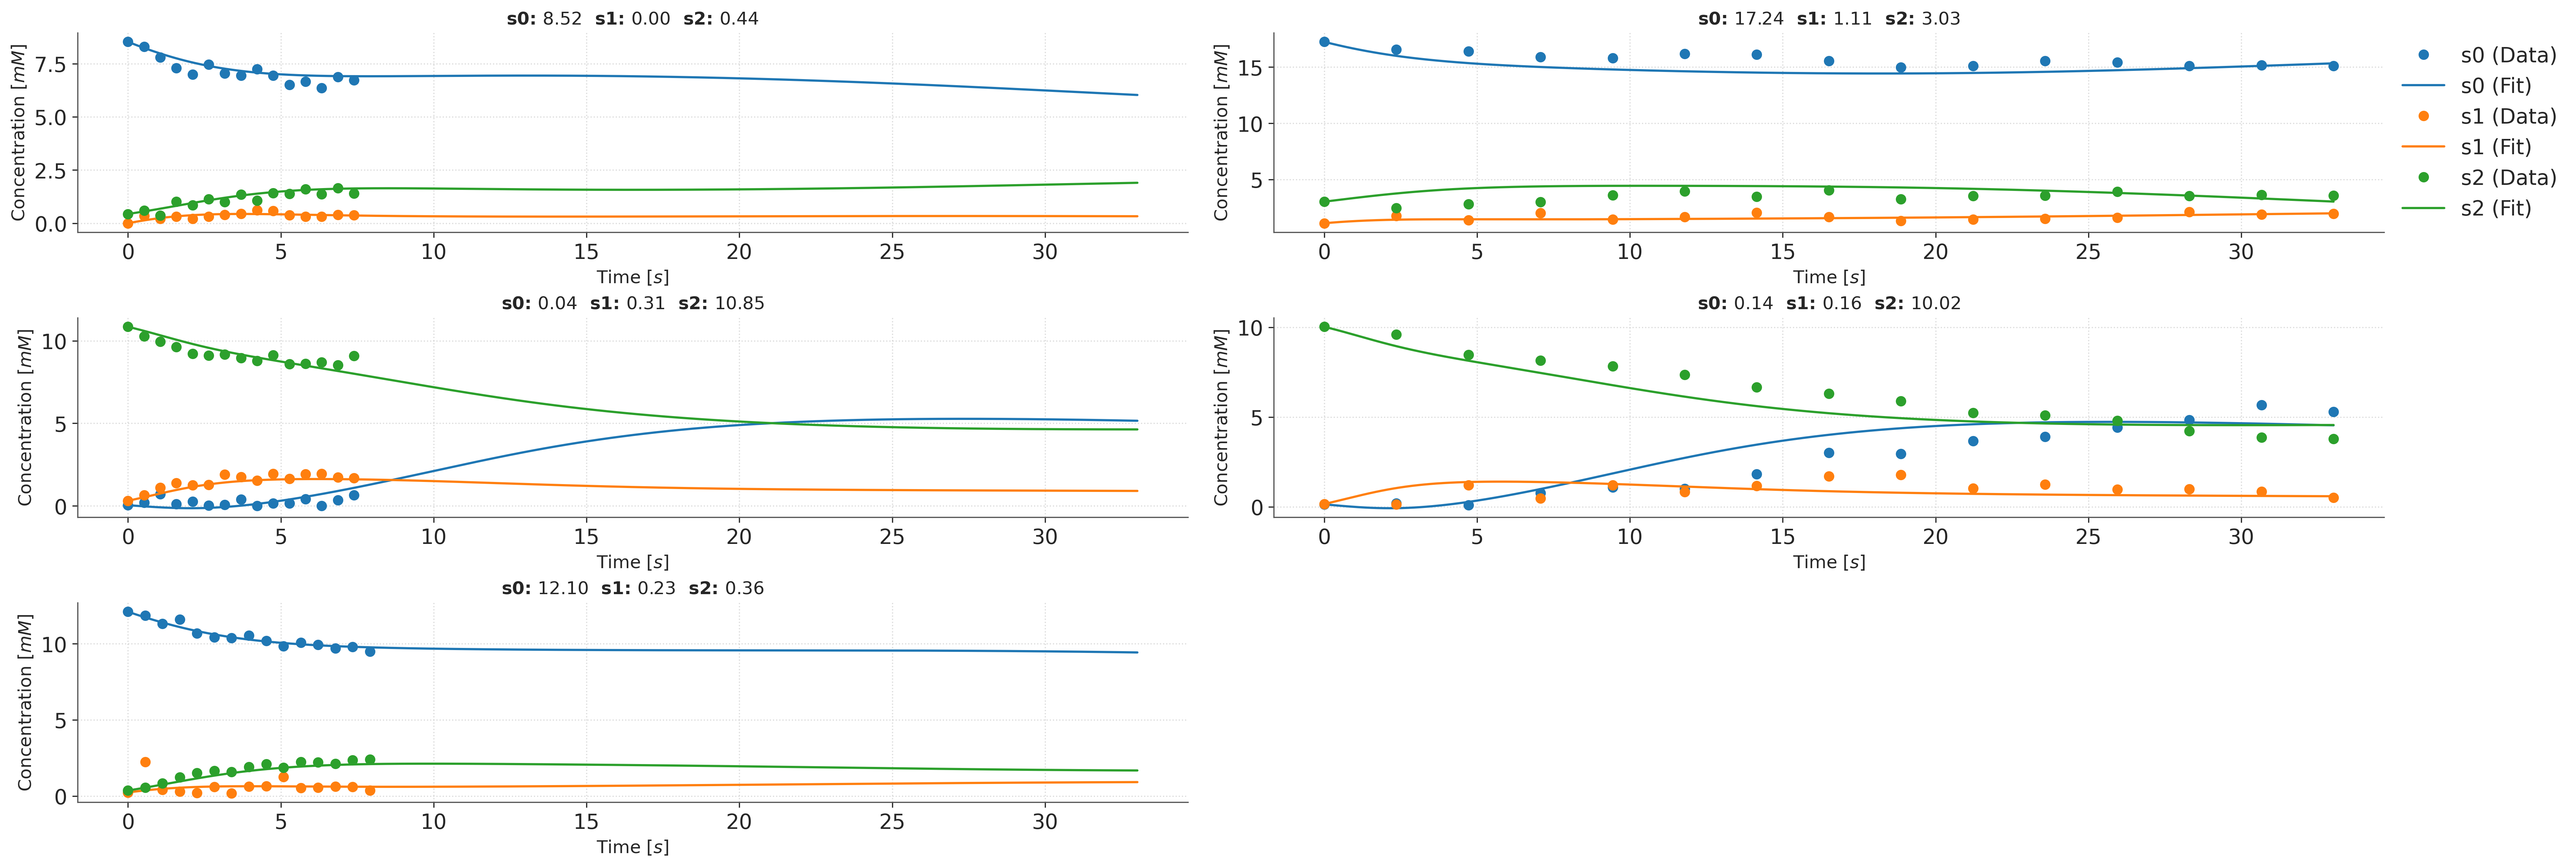

In [142]:
# Save model and visualize fit
trained.save_to_eqx("C:/Users/danic/OneDrive/Desktop/", "Set 1 Trained")
f = ctx.visualize(
    model=model,
    data=data[:5],
    times=time[:5],
    neural_ode=trained,
    initial_conditions=initial_conditions[:5],
    figsize=(8,4),
)

# Fit 

In [8]:
result, new_model = ctx.optimize(
    model=model,
    initial_conditions=initial_conditions,
    data=data,
    times=time,
    global_upper_bound=1e5,
    global_lower_bound=1e-6,
    method="bfgs"
)

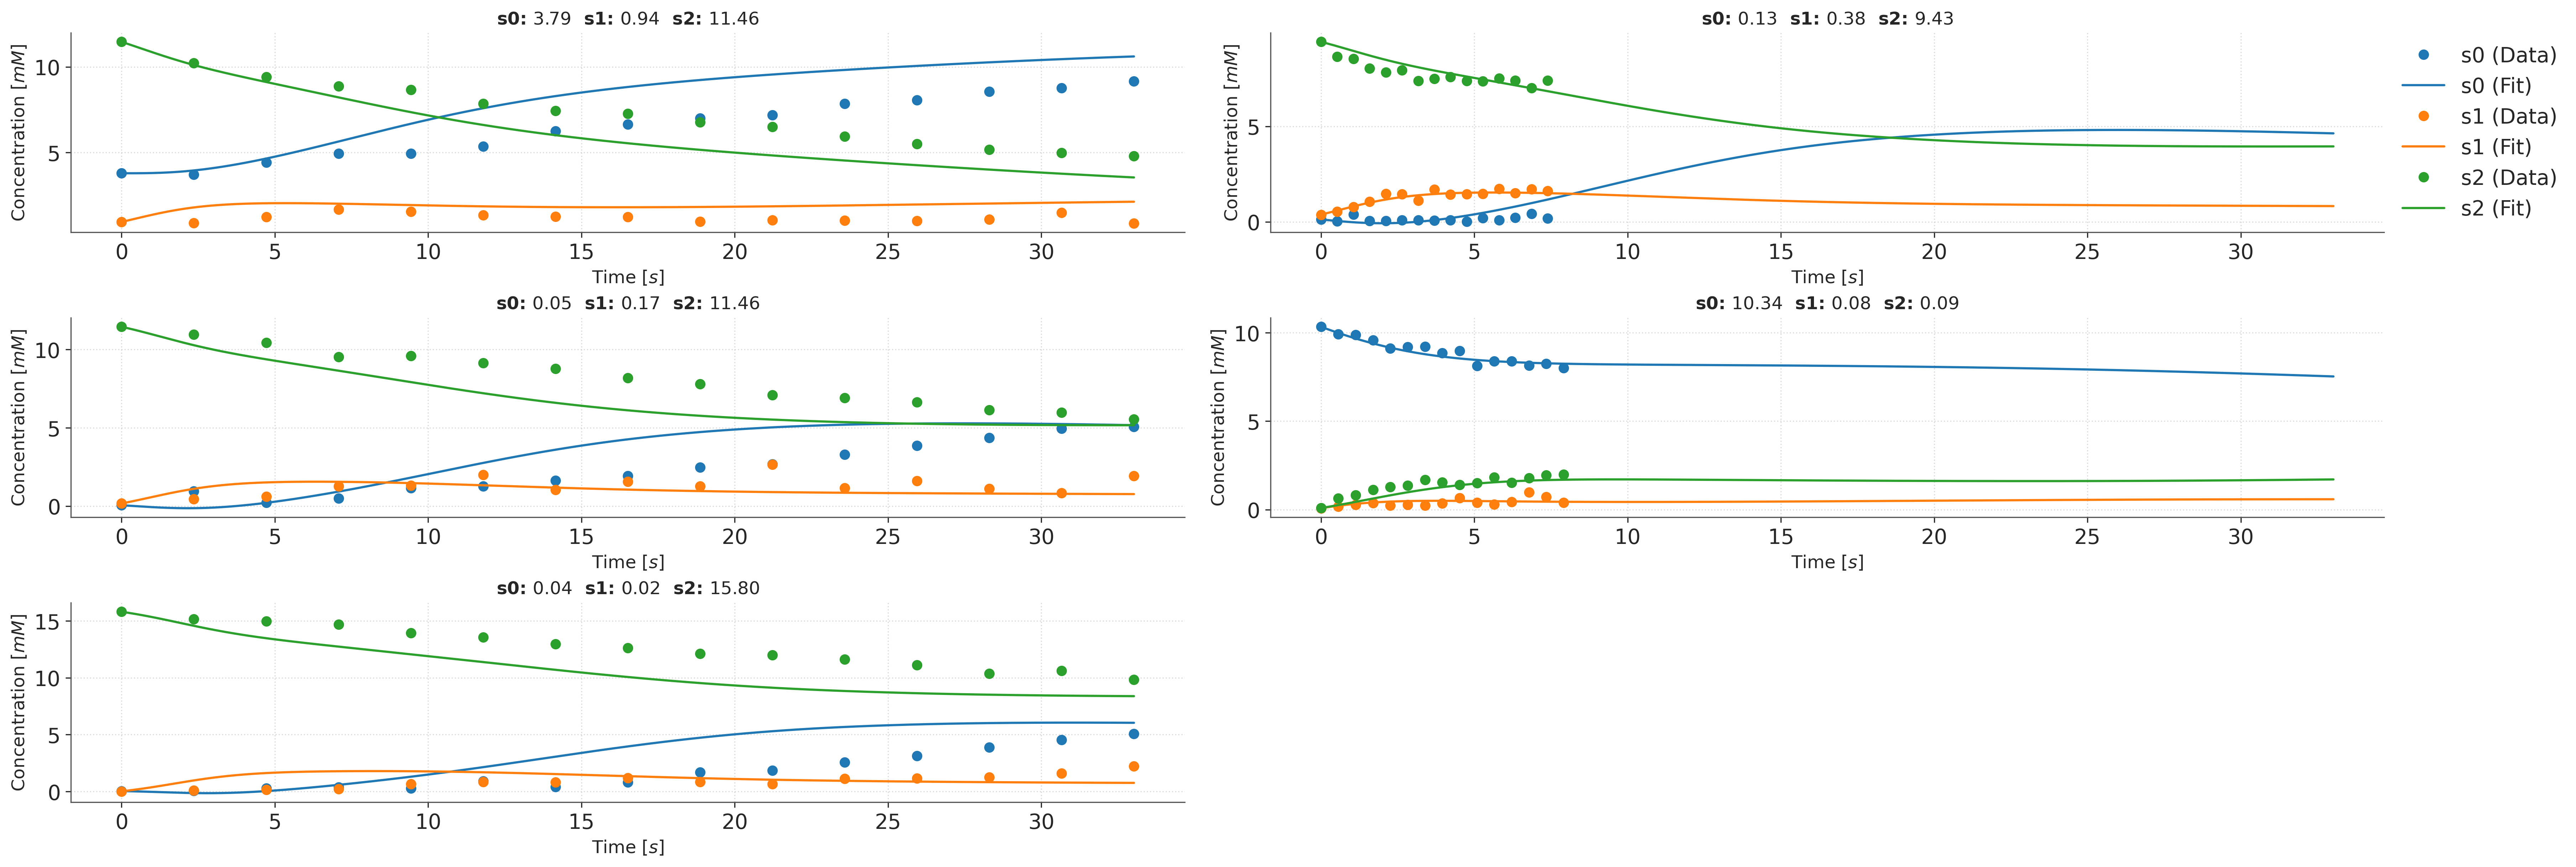

In [147]:
f = ctx.visualize(
    model=new_model,
    data=val_data[:5],
    times=val_time[:5],
    neural_ode=trained,
    initial_conditions=val_initial_conditions[:5],
    figsize=(8,4),
)

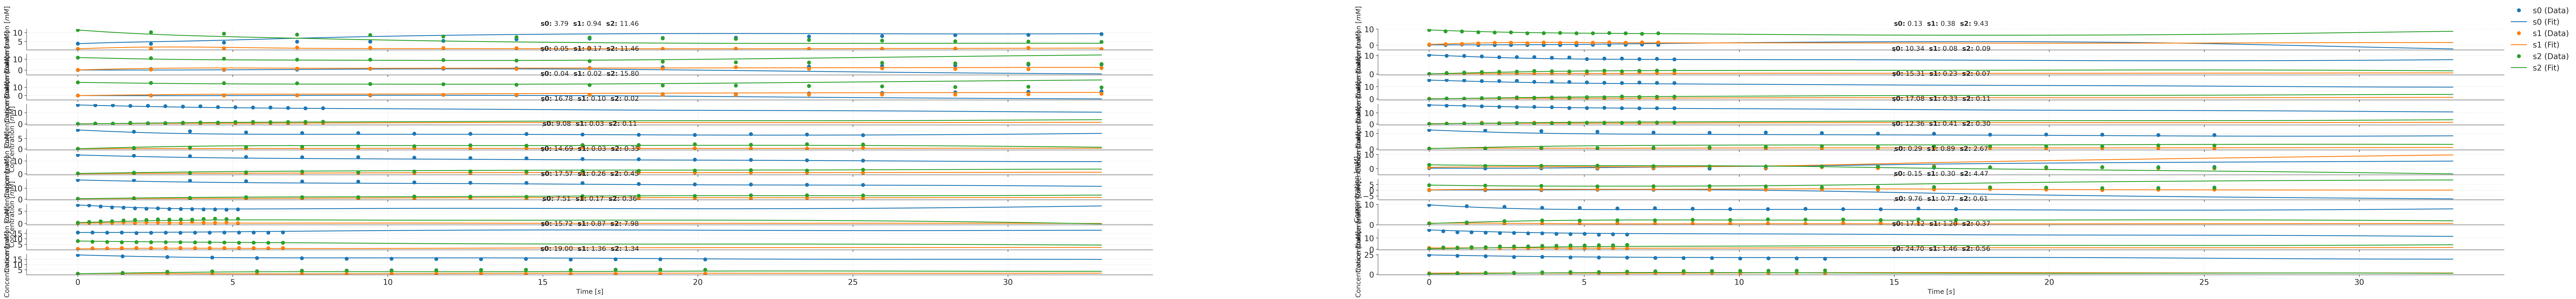

In [120]:
f = ctx.visualize(
    model=new_model,
    data=val_data,
    times=val_time,
    neural_ode=trained,
    initial_conditions=val_initial_conditions,
    figsize=(8,4),
)

In [121]:
f.set_figwidth(9)
f.set_figheight(20)


In [103]:
f.savefig("C:/Users/danic/Thesis/Data/Training_Set_1_Val_visualization.png", dpi=300, bbox_inches="tight")


In [ ]:
## Saving graph object incase I need to import later 

In [124]:

# Save the file to a specific directory
with open("C:/Users/danic/Thesis/Data/Training_Set_1_Val_visualization.pkl", "wb") as file:
    pickle.dump(f, file)


In [9]:
##Fit to val 

result, new_model = ctx.optimize(
    model=model,
    initial_conditions=val_initial_conditions,
    data=val_data,
    times=val_time,
    global_upper_bound=1e5,
    global_lower_bound=1e-6,
    method="lmfit", 
)

## HMC + NDE

In [10]:
# Initialize the model
model = ctx.Model(name="PGM ENO")

# Add species
model.add_species("s0")
model.add_species("s1")
model.add_species("s2")

# Add ODEs
model.add_ode("s0", "- (vf_pgm/k_p3ga_pgm)*(s0-s1/keq_pgm)/(1+(s1/k_p2ga_pgm)+(s0/k_p3ga_pgm))")
model.add_ode("s1", 
              """(vf_pgm/k_p3ga_pgm)*(s0-s1/keq_pgm)/(1+(s1/k_p2ga_pgm)+(s0/k_p3ga_pgm))
              - (vf_eno/k_p2ga_eno)*(s1-s2/keq_eno)/(1+(s1/k_p2ga_eno)+(s2/k_PEP_eno))
              """
             )
model.add_ode("s2", "(vf_eno/k_p2ga_eno)*(s1-s2/keq_eno)/(1+(s1/k_p2ga_eno)+(s2/k_PEP_eno))")


model

Model summary


Eq(x, Matrix([[s0, s1, s2]]))

Eq(theta, Matrix([[k_p3ga_pgm, keq_pgm, k_p2ga_pgm, vf_pgm, keq_eno, k_PEP_eno, vf_eno, k_p2ga_eno]]))

Eq(Derivative(s0, t), -vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)))

Eq(Derivative(s1, t), vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)) - vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

Eq(Derivative(s2, t), vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

name      symbol value  constant initial_value equation lower_bound  \
0   k_PEP_eno   k_PEP_eno  None     False          None     None        None   
1  k_p2ga_eno  k_p2ga_eno  None     False          None     None        None   
2  k_p2ga_pgm  k_p2ga_pgm  None     False          None     None        None   
3  k_p3ga_pgm  k_p3ga_pgm  None     False          None     None        None   
4     keq_eno     keq_eno  None     False          None     None        None   
5     keq_pgm     keq_pgm  None     False          None     None        None   
6      vf_eno      vf_eno  None     False          None     None        None   
7      vf_pgm      vf_pgm  None     False          None     None        None   

  upper_bound  
0        None  
1        None  
2        None  
3        None  
4        None  
5        None  
6        None  
7        None

In [11]:
#here we combine the HMC results in the NDE 

In [12]:
#Here we set the priors for the Monte Carlo to the parameter values generated by the NDE

model.parameters.vf_eno.value = 10.9515538
model.parameters.vf_pgm.value = 7.94317982
model.parameters.keq_pgm.value = 0.1433681
model.parameters.keq_eno.value = 3.24547102
model.parameters.k_p2ga_pgm.value = 0.25867127
model.parameters.k_p3ga_pgm.value = 55.7256096
model.parameters.k_p2ga_eno.value = 2.1542e-05
model.parameters.k_PEP_eno.value = 2.2231e-06

In [13]:
# Define Priors

model.parameters.vf_eno.prior = cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.vf_pgm.prior= cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.keq_pgm.prior= cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.k_p2ga_pgm.prior = cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.k_p3ga_pgm.prior = cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.k_p2ga_eno.prior =cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.k_PEP_eno.prior=cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.keq_eno.prior=cmc.priors.Uniform(low=1e-3, high=1e1)


In [14]:
# Perform MCMC simulation
mcmc, bayes_model = cmc.run_mcmc(
    model=model,
    data=data,
    initial_conditions=initial_conditions,
    times=time,
    yerrs=2.0,
    num_warmup=2000,
    num_samples=1000,
    dt0=0.3,
    max_steps=64**4
)

🔸 Priors
├── k_p3ga_pgm: U(low=0.001, high=10.0)
├── keq_pgm: U(low=0.001, high=10.0)
├── k_p2ga_pgm: U(low=0.001, high=10.0)
├── vf_pgm: U(low=0.001, high=10.0)
├── keq_eno: U(low=0.001, high=10.0)
├── k_PEP_eno: U(low=0.001, high=10.0)
├── vf_eno: U(low=0.001, high=10.0)
├── k_p2ga_eno: U(low=0.001, high=10.0)

🚀 Running MCMC



sample: 100%|███████████████████████████| 3000/3000 [38:26<00:00,  1.30it/s, 31 steps of size 6.86e-02. acc. prob=0.83]




🎉 Finished

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
   k_PEP_eno      0.37      0.27      0.30      0.01      0.75    556.43      1.00
  k_p2ga_eno      0.82      0.64      0.65      0.01      1.73    460.49      1.00
  k_p2ga_pgm      0.03      0.01      0.03      0.01      0.05    348.10      1.00
  k_p3ga_pgm      7.43      1.87      7.78      4.60      9.99    259.53      1.00
     keq_eno      3.56      0.22      3.55      3.18      3.90    699.71      1.00
     keq_pgm      0.10      0.01      0.10      0.09      0.12    609.57      1.00
       sigma      1.02      0.02      1.02      0.99      1.05    736.48      1.00
      vf_eno      7.61      1.78      8.05      5.00     10.00    198.34      1.00
      vf_pgm      7.26      1.81      7.38      4.73      9.95    399.63      1.00

Number of divergences: 9


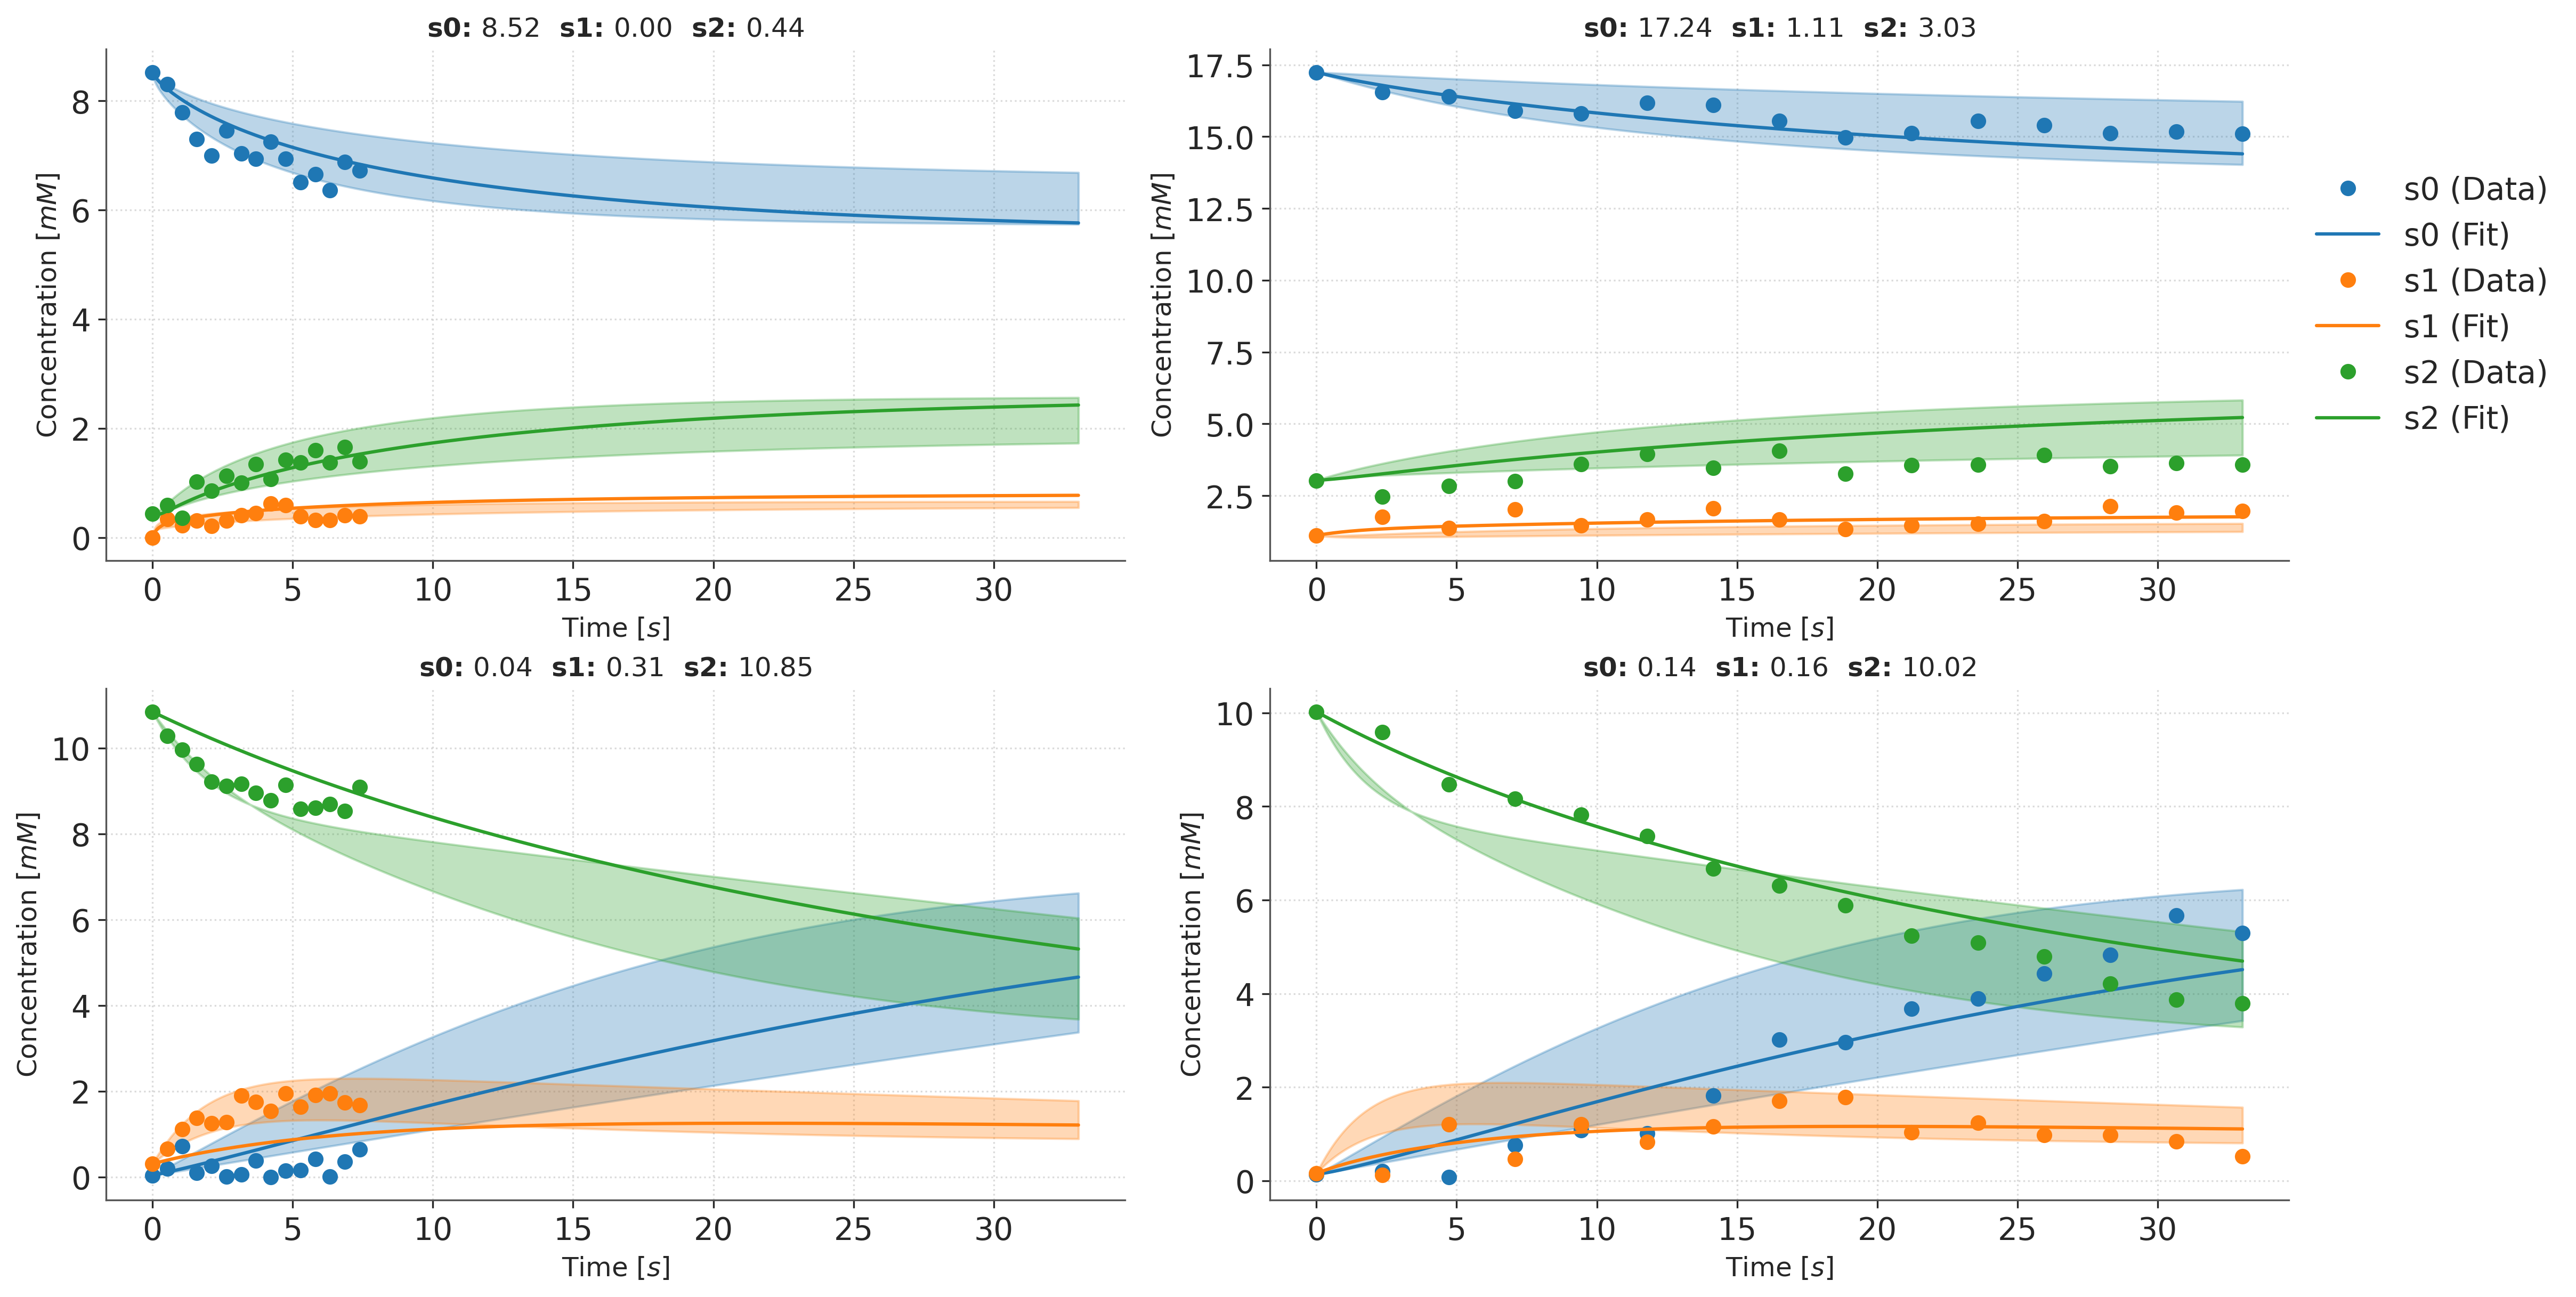

In [16]:
f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(8,4),
    mcmc=mcmc
)

C:\Users\danic\AppData\Local\Temp\ipykernel_32372\1983509386.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


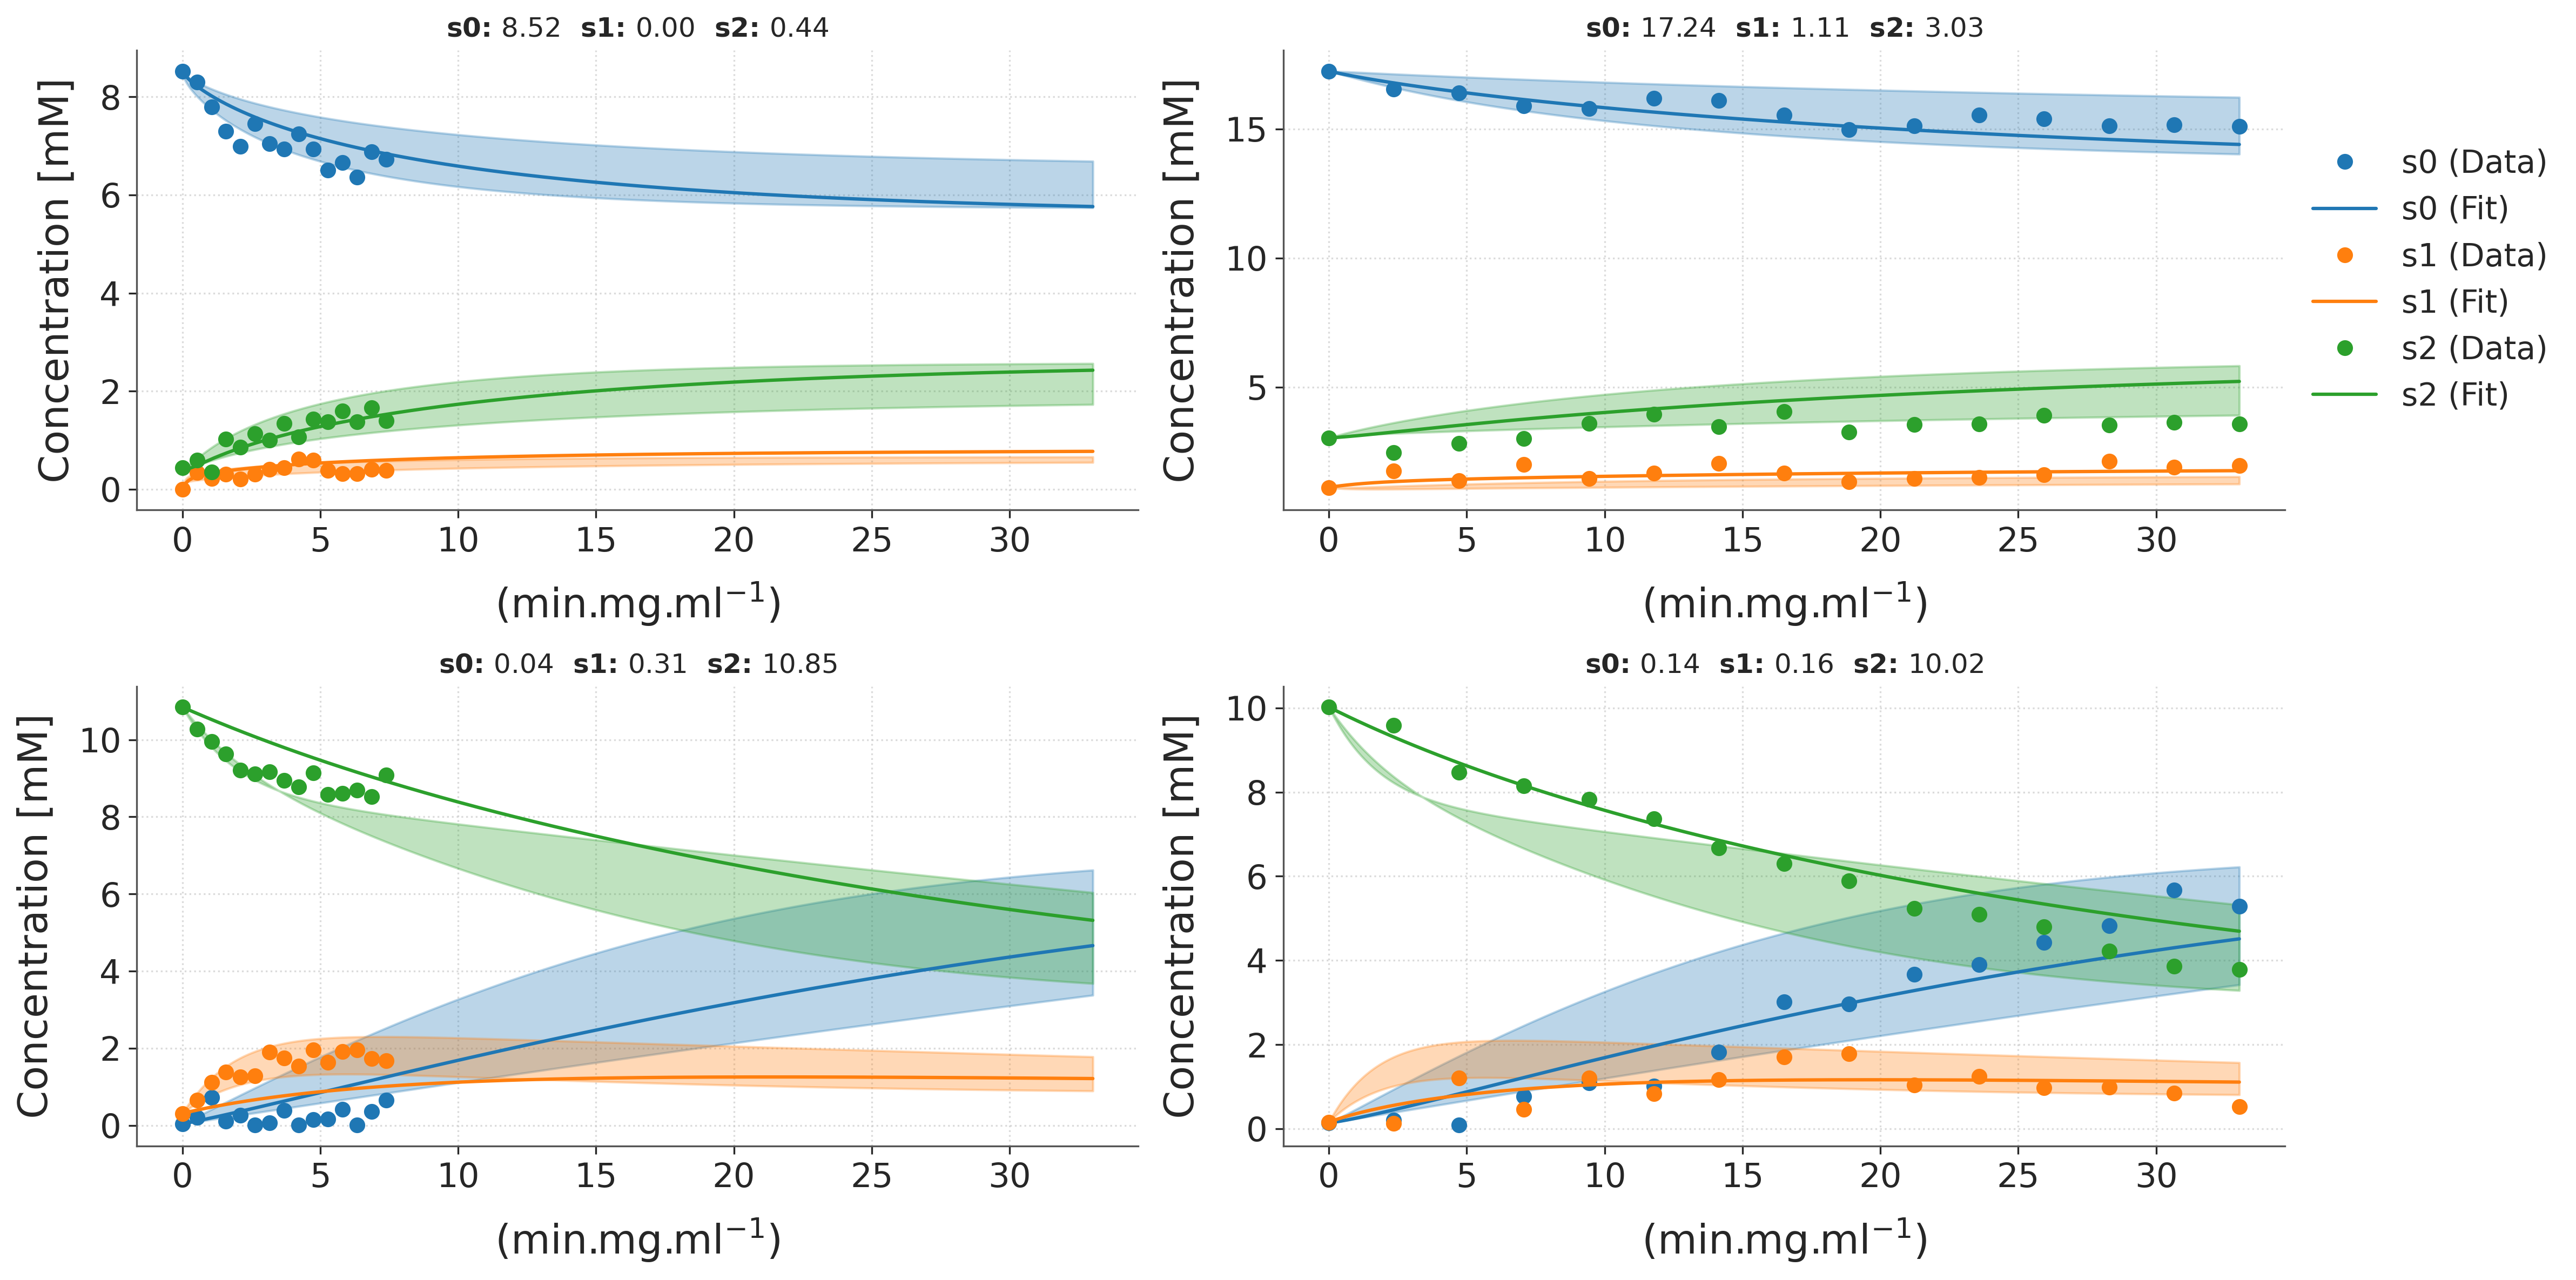

In [17]:
# Generate the figure using ctx.visualize
f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(8, 4),
    mcmc=mcmc
)

# Importing matplotlib for adjustments
import matplotlib.pyplot as plt

# Loop through all axes in the figure
for ax in f.axes:
    # Set custom axis titles
    ax.set_xlabel("(min.mg.ml$^{-1}$)", fontsize=18, labelpad=10)
    ax.set_ylabel("Concentration [mM]", fontsize=18, labelpad=10)
    
    # Adjust tick label sizes
    ax.tick_params(axis='x', labelsize=15)  # x-axis tick labels
    ax.tick_params(axis='y', labelsize=15)  # y-axis tick labels

# Add tight layout for spacing adjustments
plt.tight_layout()

# Save the figure to a file
plt.savefig("Updated_Figure_With_Axis_Titles.png", dpi=300, bbox_inches="tight")

# Display the figure
plt.show()

In [18]:
f.savefig("C:/Users/danic/Thesis/Data/Training_Set_1_MCMC_visualization.png", dpi=300, bbox_inches="tight")